In [13]:
from xai.mnist import MNIST
from xai.explainer import PermutationExplainer, ExactExplainer, KernelExplainer, DeepExplainer
import matplotlib.pyplot as plt
import random
import numpy as np

In [15]:
latent_dim = 16
device = "cuda"

mnist = MNIST((latent_dim,), device=device, hidden_layers=2)
mnist

Sequential(
  (0): Linear(in_features=784, out_features=528, bias=True)
  (1): ReLU()
  (2): Linear(in_features=528, out_features=272, bias=True)
  (3): ReLU()
  (4): Linear(in_features=272, out_features=16, bias=True)
  (5): Linear(in_features=16, out_features=14, bias=True)
  (6): ReLU()
  (7): Linear(in_features=14, out_features=12, bias=True)
  (8): ReLU()
  (9): Linear(in_features=12, out_features=10, bias=True)
  (10): Softmax(dim=1)
)

In [16]:
stats = mnist.fit_autoencoder(
    epochs=10_000,
    batch_size=256,
    loss_criterion="MSELoss",
    early_stop_cont=750,
    verbose=True,
    info="Mnist autoencoder train"
)
stats[5:].plot_loss()

Early stopping! Train-loss: 0.007351, Val-loss: 0.007979:  90%|████████▉ | 8957/10000 [02:24<00:16, 62.03it/s]


In [17]:
stats = mnist.fit_classifier_head(
    epochs=10_000,
    batch_size=256,
    early_stop_cont=750,
    verbose=True,
    info="Mnist classifier-head train"
)
stats[5:].plot_loss()

Early stopping! Train-loss: -0.866495, Val-loss: -0.864437:  44%|████▎     | 4370/10000 [00:51<01:06, 84.68it/s]


/tmp/ipykernel_2229/4108273777.py:41: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



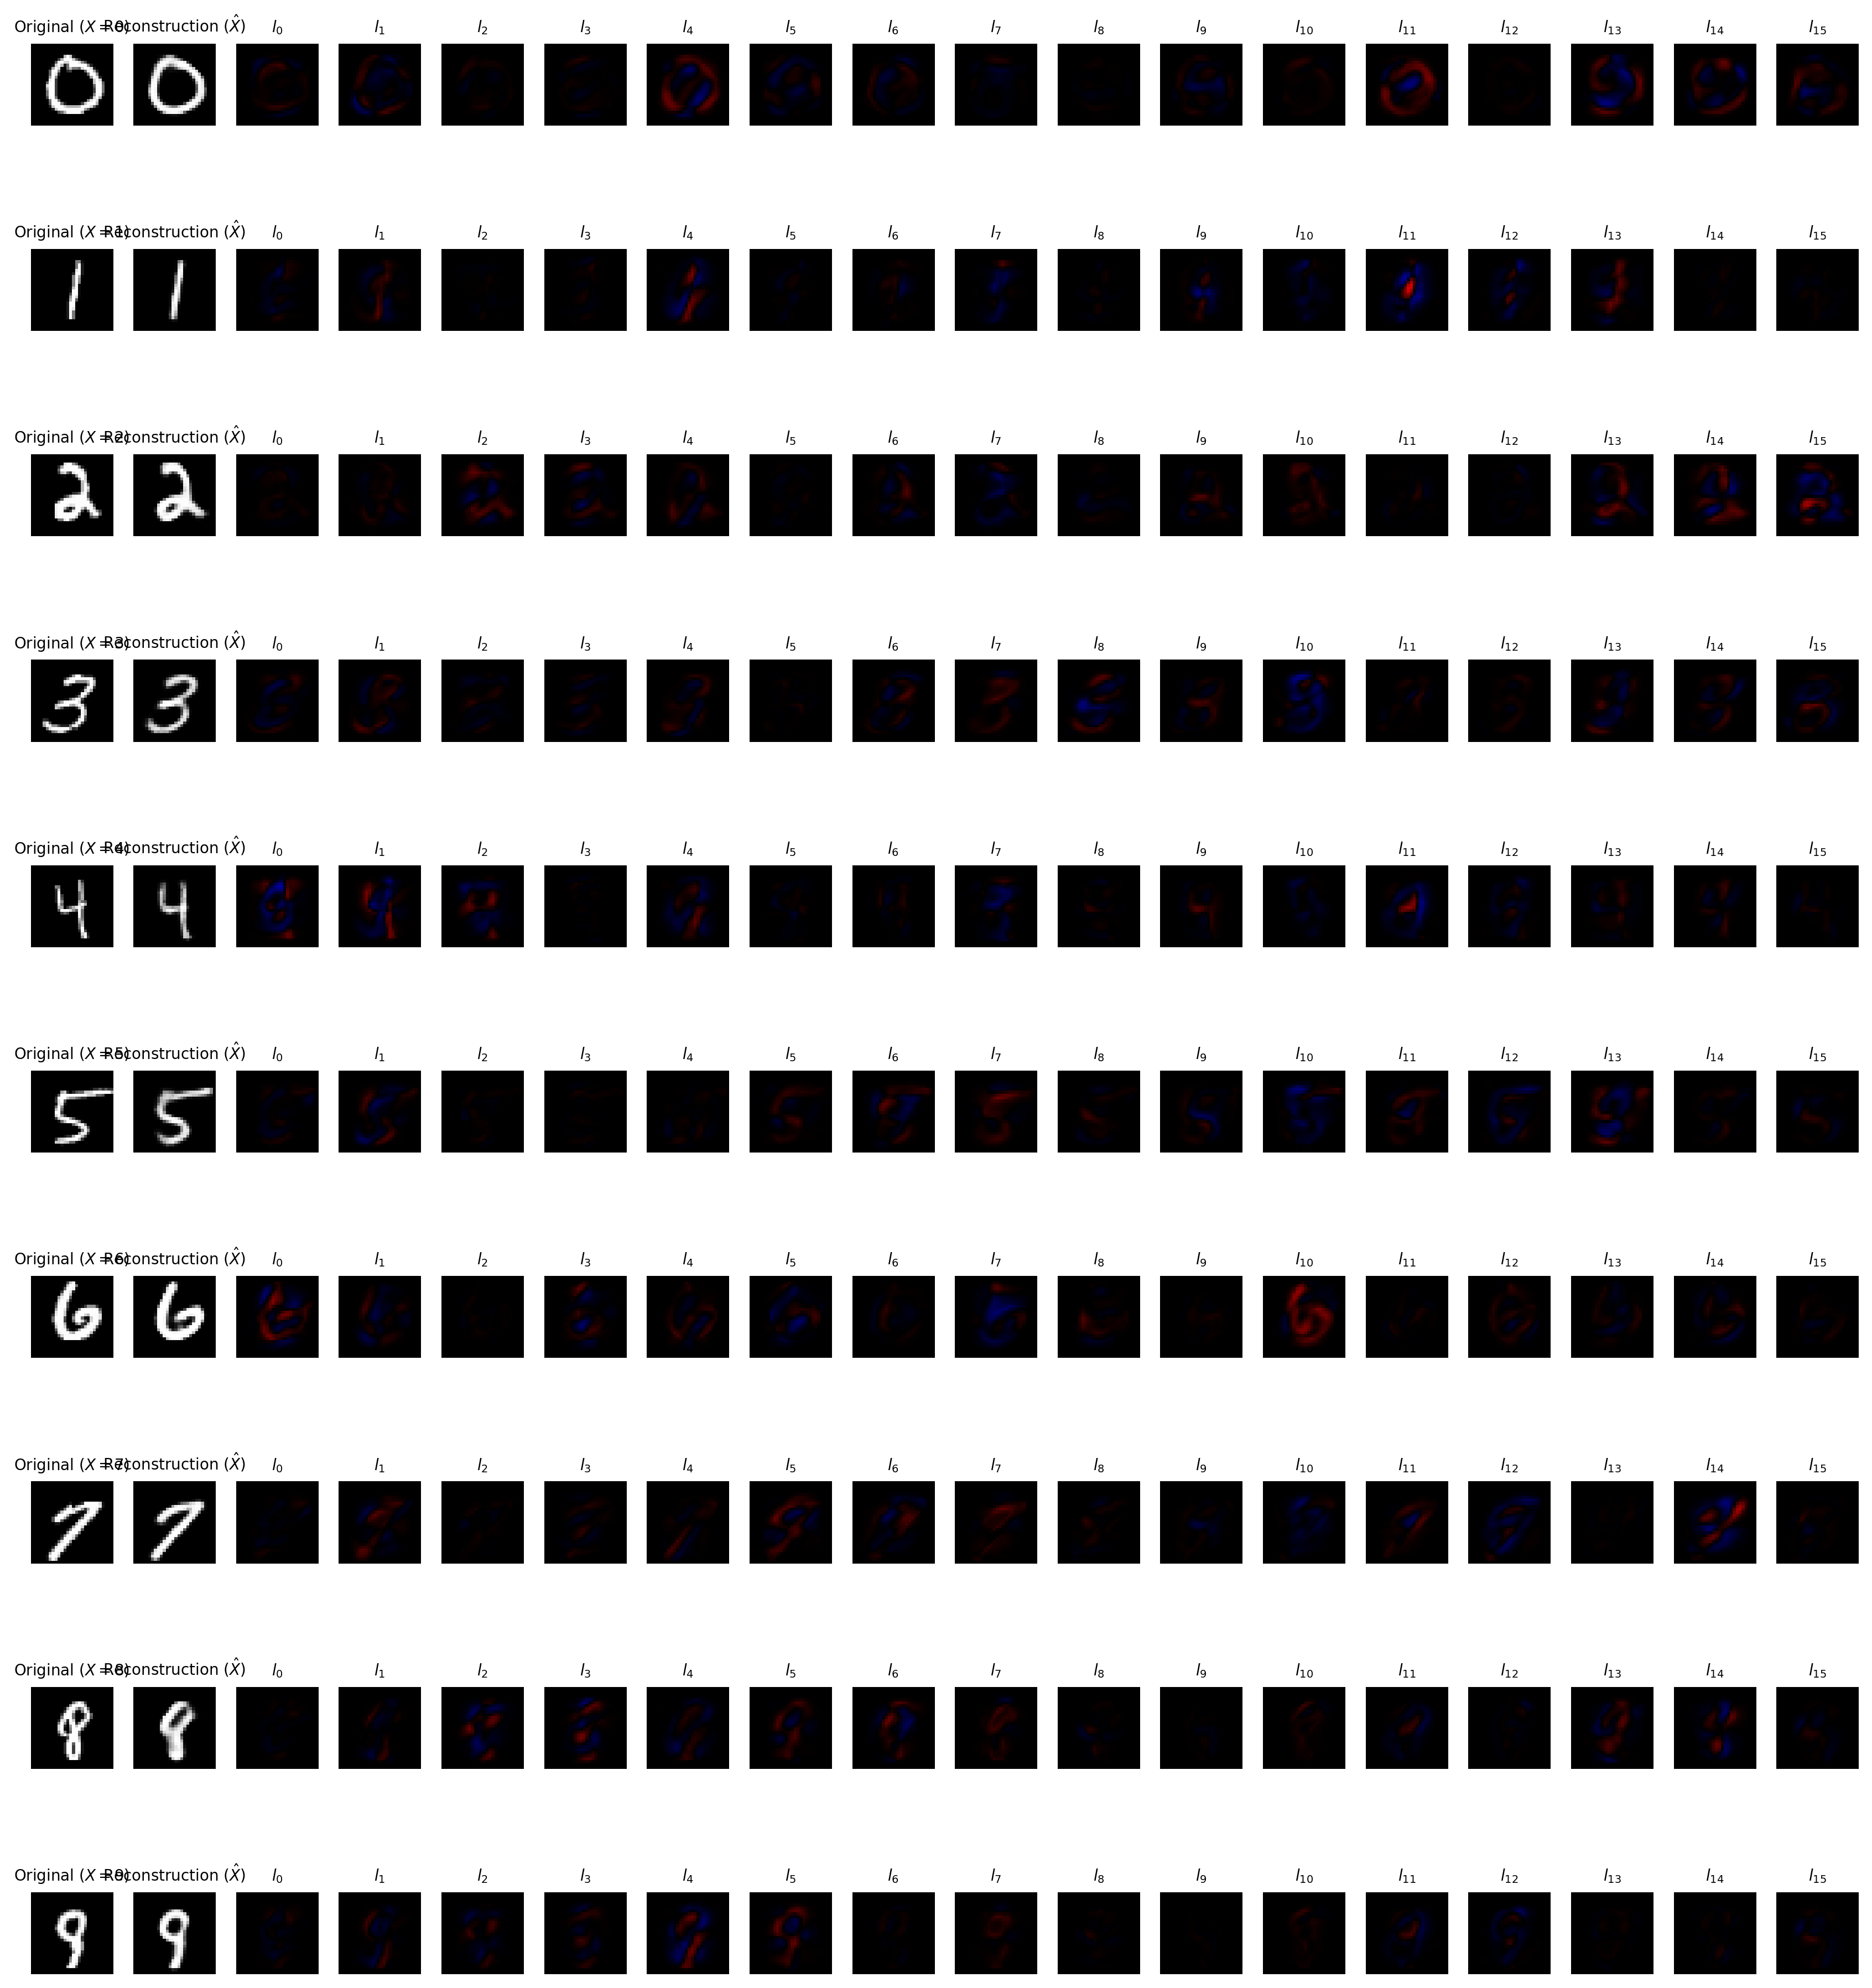

In [18]:
fig = plt.figure(figsize=(15,15), dpi=250) 
rows = 10
columns = latent_dim + 4

for row in range(rows):
    slot = row*columns

    sample,label = mnist.get_sample(digit=row)
    sample = sample.numpy(force=True)
    label = int(label.item())
    predict = mnist(sample)
    recon = predict.reconstruction().numpy(force=True)
    digit = predict.digits()[0]
    cls = predict.classification().tolist()

    recon_xai = predict.explain("reconstruction", "permutation")
    feature_sum = recon_xai.feature_sum()
    norm = max([recon_xai.abs().max(), feature_sum.abs().max()])


    fig.add_subplot(rows,columns,slot+1)
    plt.imshow(sample, cmap="gray")
    plt.axis('off')
    plt.title(f"Original ($X={{{label}}}$)", size=8)
        
    fig.add_subplot(rows,columns,slot+2)
    plt.imshow(recon, cmap="gray")
    plt.axis('off')
    plt.title("Reconstruction ($\hat{{X}}$)", size=8)

    for j,image in enumerate(recon_xai.to_rgb(norm)):
        fig.add_subplot(rows,columns,slot+j+3)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"$l_{{{j}}}$", size=8)

    


fig.tight_layout()
fig.show()

/tmp/ipykernel_2229/1166781231.py:82: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



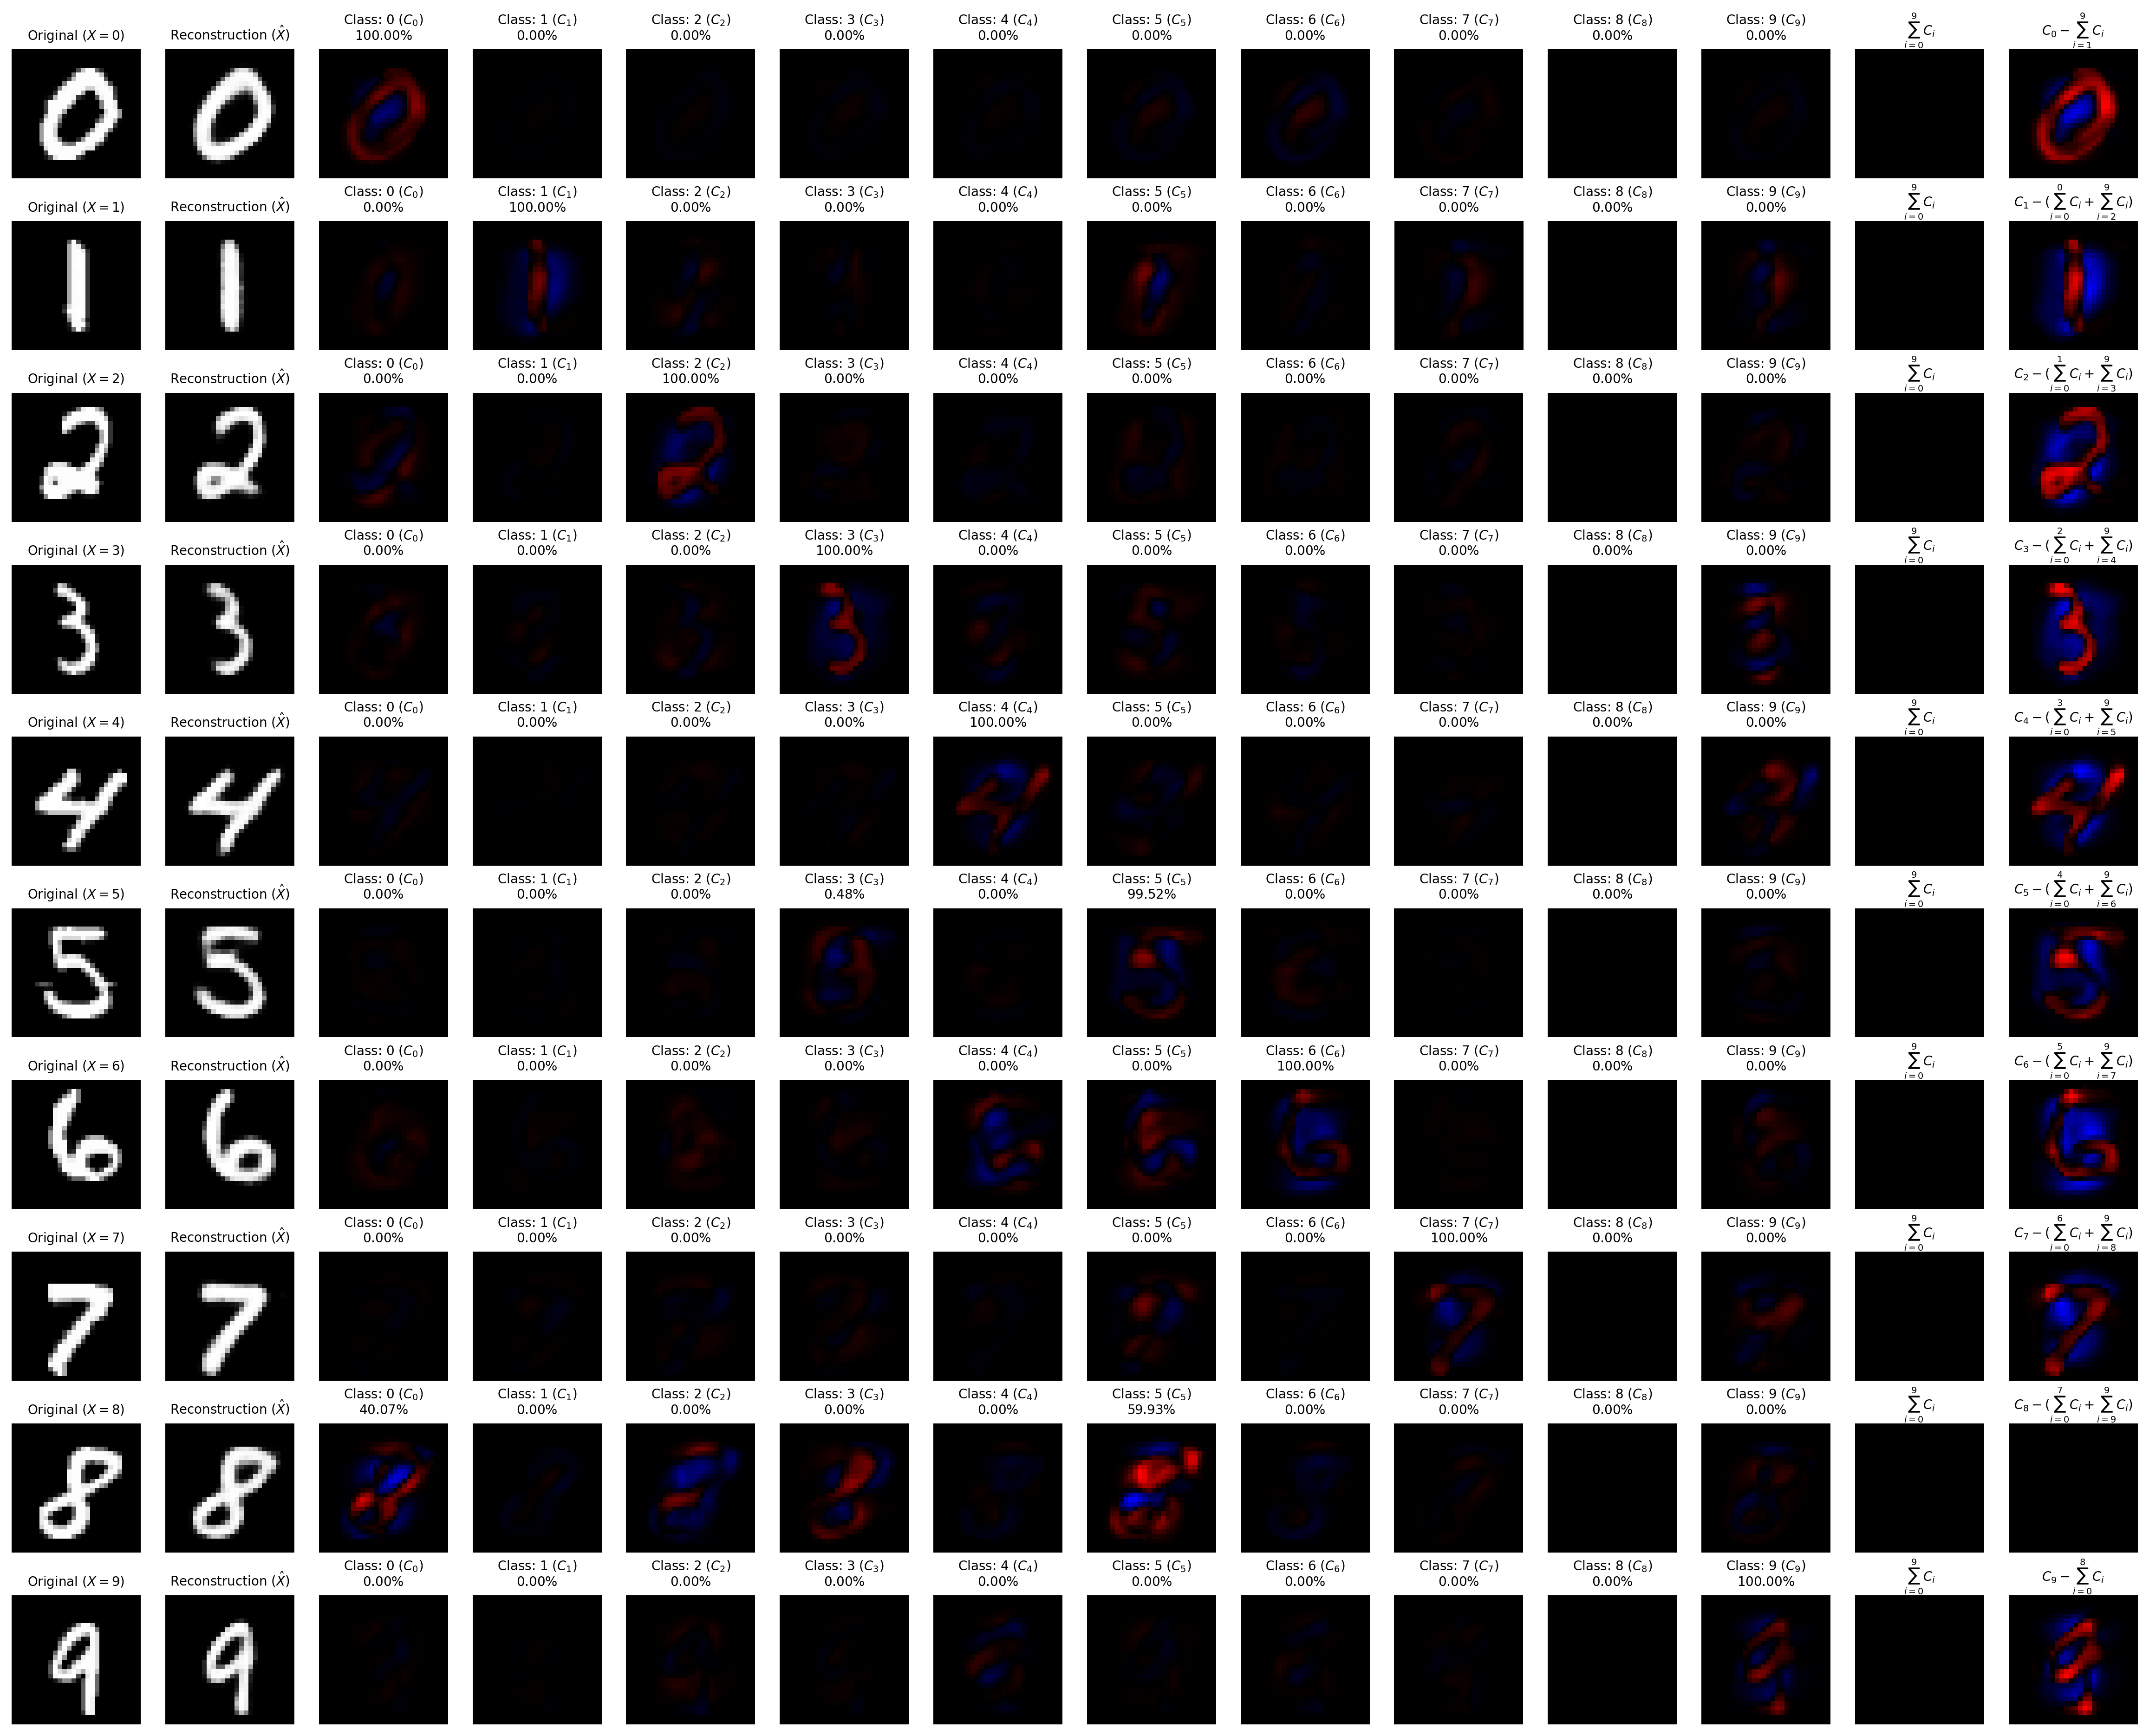

In [19]:
fig = plt.figure(figsize=(20,15), dpi=250) 
rows = 10
columns = 15

for row in range(rows):
    slot = row*columns

    sample,label = mnist.get_sample(digit=row)
    sample = sample.numpy(force=True)
    label = int(label.item())
    predict = mnist(sample)
    recon = predict.reconstruction().numpy(force=True)
    digit = predict.digits()[0]
    cls = predict.classification().tolist()

    recon_xai = predict.explain("reconstruction", "permutation").shap_values
    cls_xai = predict.explain("classification", "permutation").shap_values

    fig.add_subplot(rows,columns,slot+1)
    plt.imshow(sample, cmap="gray")
    plt.axis('off')
    plt.title(f"Original ($X={{{label}}}$)", size=8)
        
    fig.add_subplot(rows,columns,slot+2)
    plt.imshow(recon, cmap="gray")
    plt.axis('off')
    plt.title("Reconstruction ($\hat{{X}}$)", size=8)

    shaps = []
        
    for j in range(10):
        shap = np.zeros_like(recon_xai)
        for k in range(latent_dim):
            shap[k] = recon_xai[k] * cls_xai[k,j]

        shap = shap.sum(axis=0)
        shaps.append(shap)

    shaps = np.stack(shaps)
    delta_shap: np.ndarray = shaps[label] - (shaps[:label].sum(axis=0) + shaps[label+1:].sum(axis=0))
    shap_sum = shaps.sum(axis=0)
    norm = max([np.max(np.abs(shaps)), np.max(np.abs(delta_shap)), np.max(np.abs(shap_sum))])

    for j,shap in enumerate(shaps):
        fig.add_subplot(rows,columns,slot+j+3)
        im = np.zeros((28,28,3), dtype=np.float32)
        red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
        blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
        im[:,:,0] = red
        im[:,:,2] = blue
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"Class: {j} ($C_{j}$)\n${cls[j]*100:.2f}$%", size=8)

    
    fig.add_subplot(rows,columns,slot+j+4)
    im = np.zeros((28,28,3), dtype=np.float32)
    red = np.where(shap_sum > 0, shap_sum/norm, np.zeros_like(shap_sum))
    blue = np.where(shap_sum < 0, -shap_sum/norm, np.zeros_like(shap_sum))
    im[:,:,0] = red
    im[:,:,2] = blue
    plt.imshow(im)
    plt.axis('off')
    plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{C_i}}$", size=8)

    fig.add_subplot(rows,columns,slot+j+5)
    im = np.zeros((28,28,3), dtype=np.float32)
    red = np.where(delta_shap > 0, delta_shap/norm, np.zeros_like(delta_shap))
    blue = np.where(delta_shap < 0, -delta_shap/norm, np.zeros_like(delta_shap))
    im[:,:,0] = red
    im[:,:,2] = blue
    plt.imshow(im)
    plt.axis('off')
    if row == 0:
        plt.title(f"$C_{{{label}}} - \sum_{{i={1}}}^{{{rows-1}}}{{C_i}}$", size=8)
    elif row == (rows - 1):
        plt.title(f"$C_{{{label}}} - \sum_{{i={0}}}^{{{rows-2}}}{{C_i}}$", size=8)
    else:
        plt.title(f"$C_{{{label}}} - (\sum_{{i={0}}}^{{{label-1}}}{{C_i}} + \sum_{{i={label+1}}}^{{{rows-1}}}{{C_i}})$", size=8)

fig.tight_layout()
fig.show()

In [ ]:
fig = plt.figure(figsize=(20,15), dpi=250) 
rows = 10
columns = 15
explainer = KernelExplainer(mnist, mnist.val_data)

for row in range(rows):
    slot = row*columns

    sample,label = mnist.get_sample(digit=row)
    sample = sample.numpy(force=True)
    label = int(label.item())
    predict = mnist(sample)
    recon = predict.reconstruction().numpy(force=True)
    digit = predict.digits()[0]
    cls = predict.classification().tolist()

    xai = np.moveaxis(explainer.explain(sample, verbose=True)[0].shap_values, source=2, destination=0)

    fig.add_subplot(rows,columns,slot+1)
    plt.imshow(sample, cmap="gray")
    plt.axis('off')
    plt.title(f"Original ($X={{{label}}}$)", size=8)
        
    fig.add_subplot(rows,columns,slot+2)
    plt.imshow(recon, cmap="gray")
    plt.axis('off')
    plt.title("Reconstruction ($\hat{{X}}$)", size=8)

    shaps = np.stack(xai)
    delta_shap: np.ndarray = shaps[label] - (shaps[:label].sum(axis=0) + shaps[label+1:].sum(axis=0))
    shap_sum = shaps.sum(axis=0)
    norm = max([np.max(np.abs(shaps)), np.max(np.abs(delta_shap)), np.max(np.abs(shap_sum))])

    for j,shap in enumerate(shaps):
        fig.add_subplot(rows,columns,slot+j+3)
        im = np.zeros((28,28,3), dtype=np.float32)
        red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
        blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
        im[:,:,0] = red
        im[:,:,2] = blue
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"Class: {j} ($C_{j}$)\n${cls[j]*100:.2f}$%", size=8)

    
    fig.add_subplot(rows,columns,slot+j+4)
    im = np.zeros((28,28,3), dtype=np.float32)
    red = np.where(shap_sum > 0, shap_sum/norm, np.zeros_like(shap_sum))
    blue = np.where(shap_sum < 0, -shap_sum/norm, np.zeros_like(shap_sum))
    im[:,:,0] = red
    im[:,:,2] = blue
    plt.imshow(im)
    plt.axis('off')
    plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{C_i}}$", size=8)

    fig.add_subplot(rows,columns,slot+j+5)
    im = np.zeros((28,28,3), dtype=np.float32)
    red = np.where(delta_shap > 0, delta_shap/norm, np.zeros_like(delta_shap))
    blue = np.where(delta_shap < 0, -delta_shap/norm, np.zeros_like(delta_shap))
    im[:,:,0] = red
    im[:,:,2] = blue
    plt.imshow(im)
    plt.axis('off')
    if row == 0:
        plt.title(f"$C_{{{label}}} - \sum_{{i={1}}}^{{{rows-1}}}{{C_i}}$", size=8)
    elif row == (rows - 1):
        plt.title(f"$C_{{{label}}} - \sum_{{i={0}}}^{{{rows-2}}}{{C_i}}$", size=8)
    else:
        plt.title(f"$C_{{{label}}} - (\sum_{{i={0}}}^{{{label-1}}}{{C_i}} + \sum_{{i={label+1}}}^{{{rows-1}}}{{C_i}})$", size=8)

fig.tight_layout()
fig.show()

In [23]:
samples = []

for i in range(rows):
    samples.append(mnist.get_sample(digit=i))

/tmp/ipykernel_2229/2366673017.py:73: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



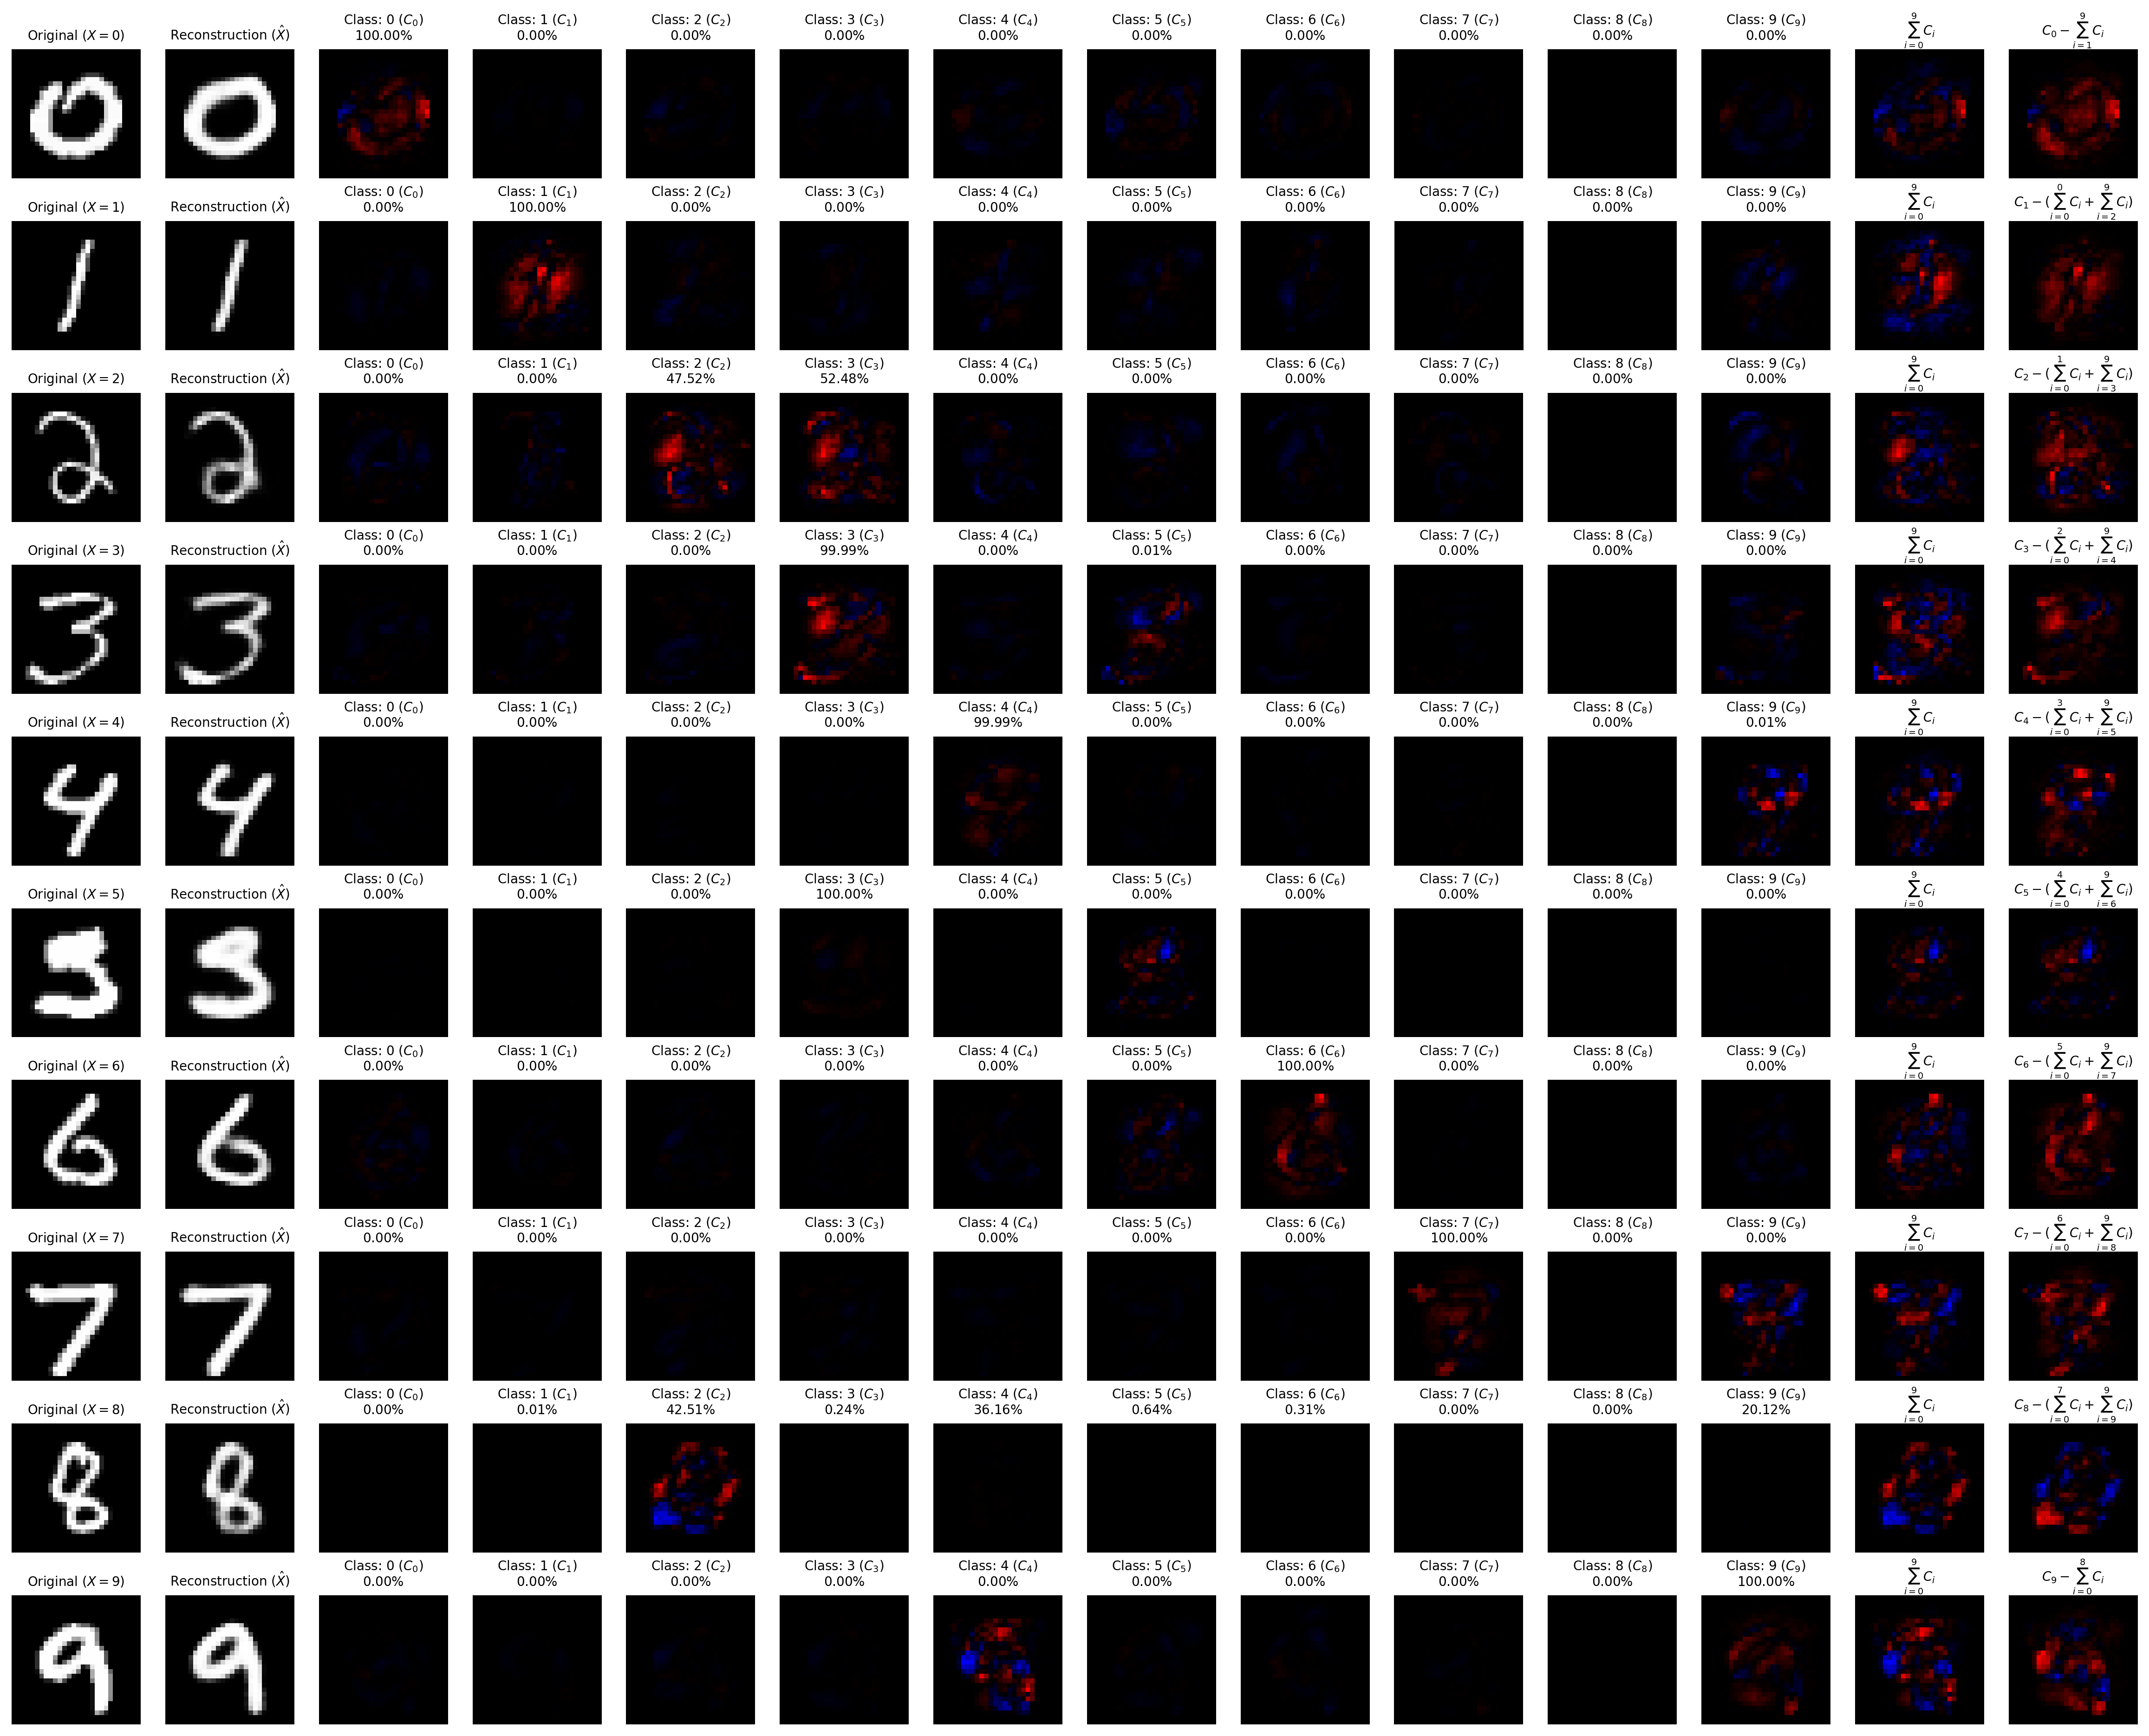

In [24]:
fig = plt.figure(figsize=(20,15), dpi=250) 
rows = 10
columns = 15
explainer = DeepExplainer(mnist, mnist.val_data)

for row in range(rows):
    slot = row*columns

    sample,label = samples[row]
    sample = sample.numpy(force=True)
    label = int(label.item())
    predict = mnist(sample)
    recon = predict.reconstruction().numpy(force=True)
    digit = predict.digits()[0]
    cls = predict.classification().tolist()

    xai = explainer.explain(sample)[0].reshape((-1,28,28))

    fig.add_subplot(rows,columns,slot+1)
    plt.imshow(sample, cmap="gray")
    plt.axis('off')
    plt.title(f"Original ($X={{{label}}}$)", size=8)
        
    fig.add_subplot(rows,columns,slot+2)
    plt.imshow(recon, cmap="gray")
    plt.axis('off')
    plt.title("Reconstruction ($\hat{{X}}$)", size=8)

    shaps = np.stack(xai)
    delta_shap: np.ndarray = shaps[label] - (shaps[:label].sum(axis=0) + shaps[label+1:].sum(axis=0))
    shap_sum = shaps.sum(axis=0)
    norm = max([np.max(np.abs(shaps))])

    for j,shap in enumerate(shaps):
        fig.add_subplot(rows,columns,slot+j+3)
        im = np.zeros((28,28,3), dtype=np.float32)
        red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
        blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
        im[:,:,0] = red
        im[:,:,2] = blue
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"Class: {j} ($C_{j}$)\n${cls[j]*100:.2f}$%", size=8)

    norm = max([np.max(np.abs(shap_sum))])
    fig.add_subplot(rows,columns,slot+j+4)
    im = np.zeros((28,28,3), dtype=np.float32)
    red = np.where(shap_sum > 0, shap_sum/norm, np.zeros_like(shap_sum))
    blue = np.where(shap_sum < 0, -shap_sum/norm, np.zeros_like(shap_sum))
    im[:,:,0] = red
    im[:,:,2] = blue
    plt.imshow(im)
    plt.axis('off')
    plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{C_i}}$", size=8)

    norm = max([np.max(np.abs(delta_shap))])
    fig.add_subplot(rows,columns,slot+j+5)
    im = np.zeros((28,28,3), dtype=np.float32)
    red = np.where(delta_shap > 0, delta_shap/norm, np.zeros_like(delta_shap))
    blue = np.where(delta_shap < 0, -delta_shap/norm, np.zeros_like(delta_shap))
    im[:,:,0] = red
    im[:,:,2] = blue
    plt.imshow(im)
    plt.axis('off')
    if row == 0:
        plt.title(f"$C_{{{label}}} - \sum_{{i={1}}}^{{{rows-1}}}{{C_i}}$", size=8)
    elif row == (rows - 1):
        plt.title(f"$C_{{{label}}} - \sum_{{i={0}}}^{{{rows-2}}}{{C_i}}$", size=8)
    else:
        plt.title(f"$C_{{{label}}} - (\sum_{{i={0}}}^{{{label-1}}}{{C_i}} + \sum_{{i={label+1}}}^{{{rows-1}}}{{C_i}})$", size=8)

fig.tight_layout()
fig.show()

/tmp/ipykernel_2229/1650000947.py:77: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



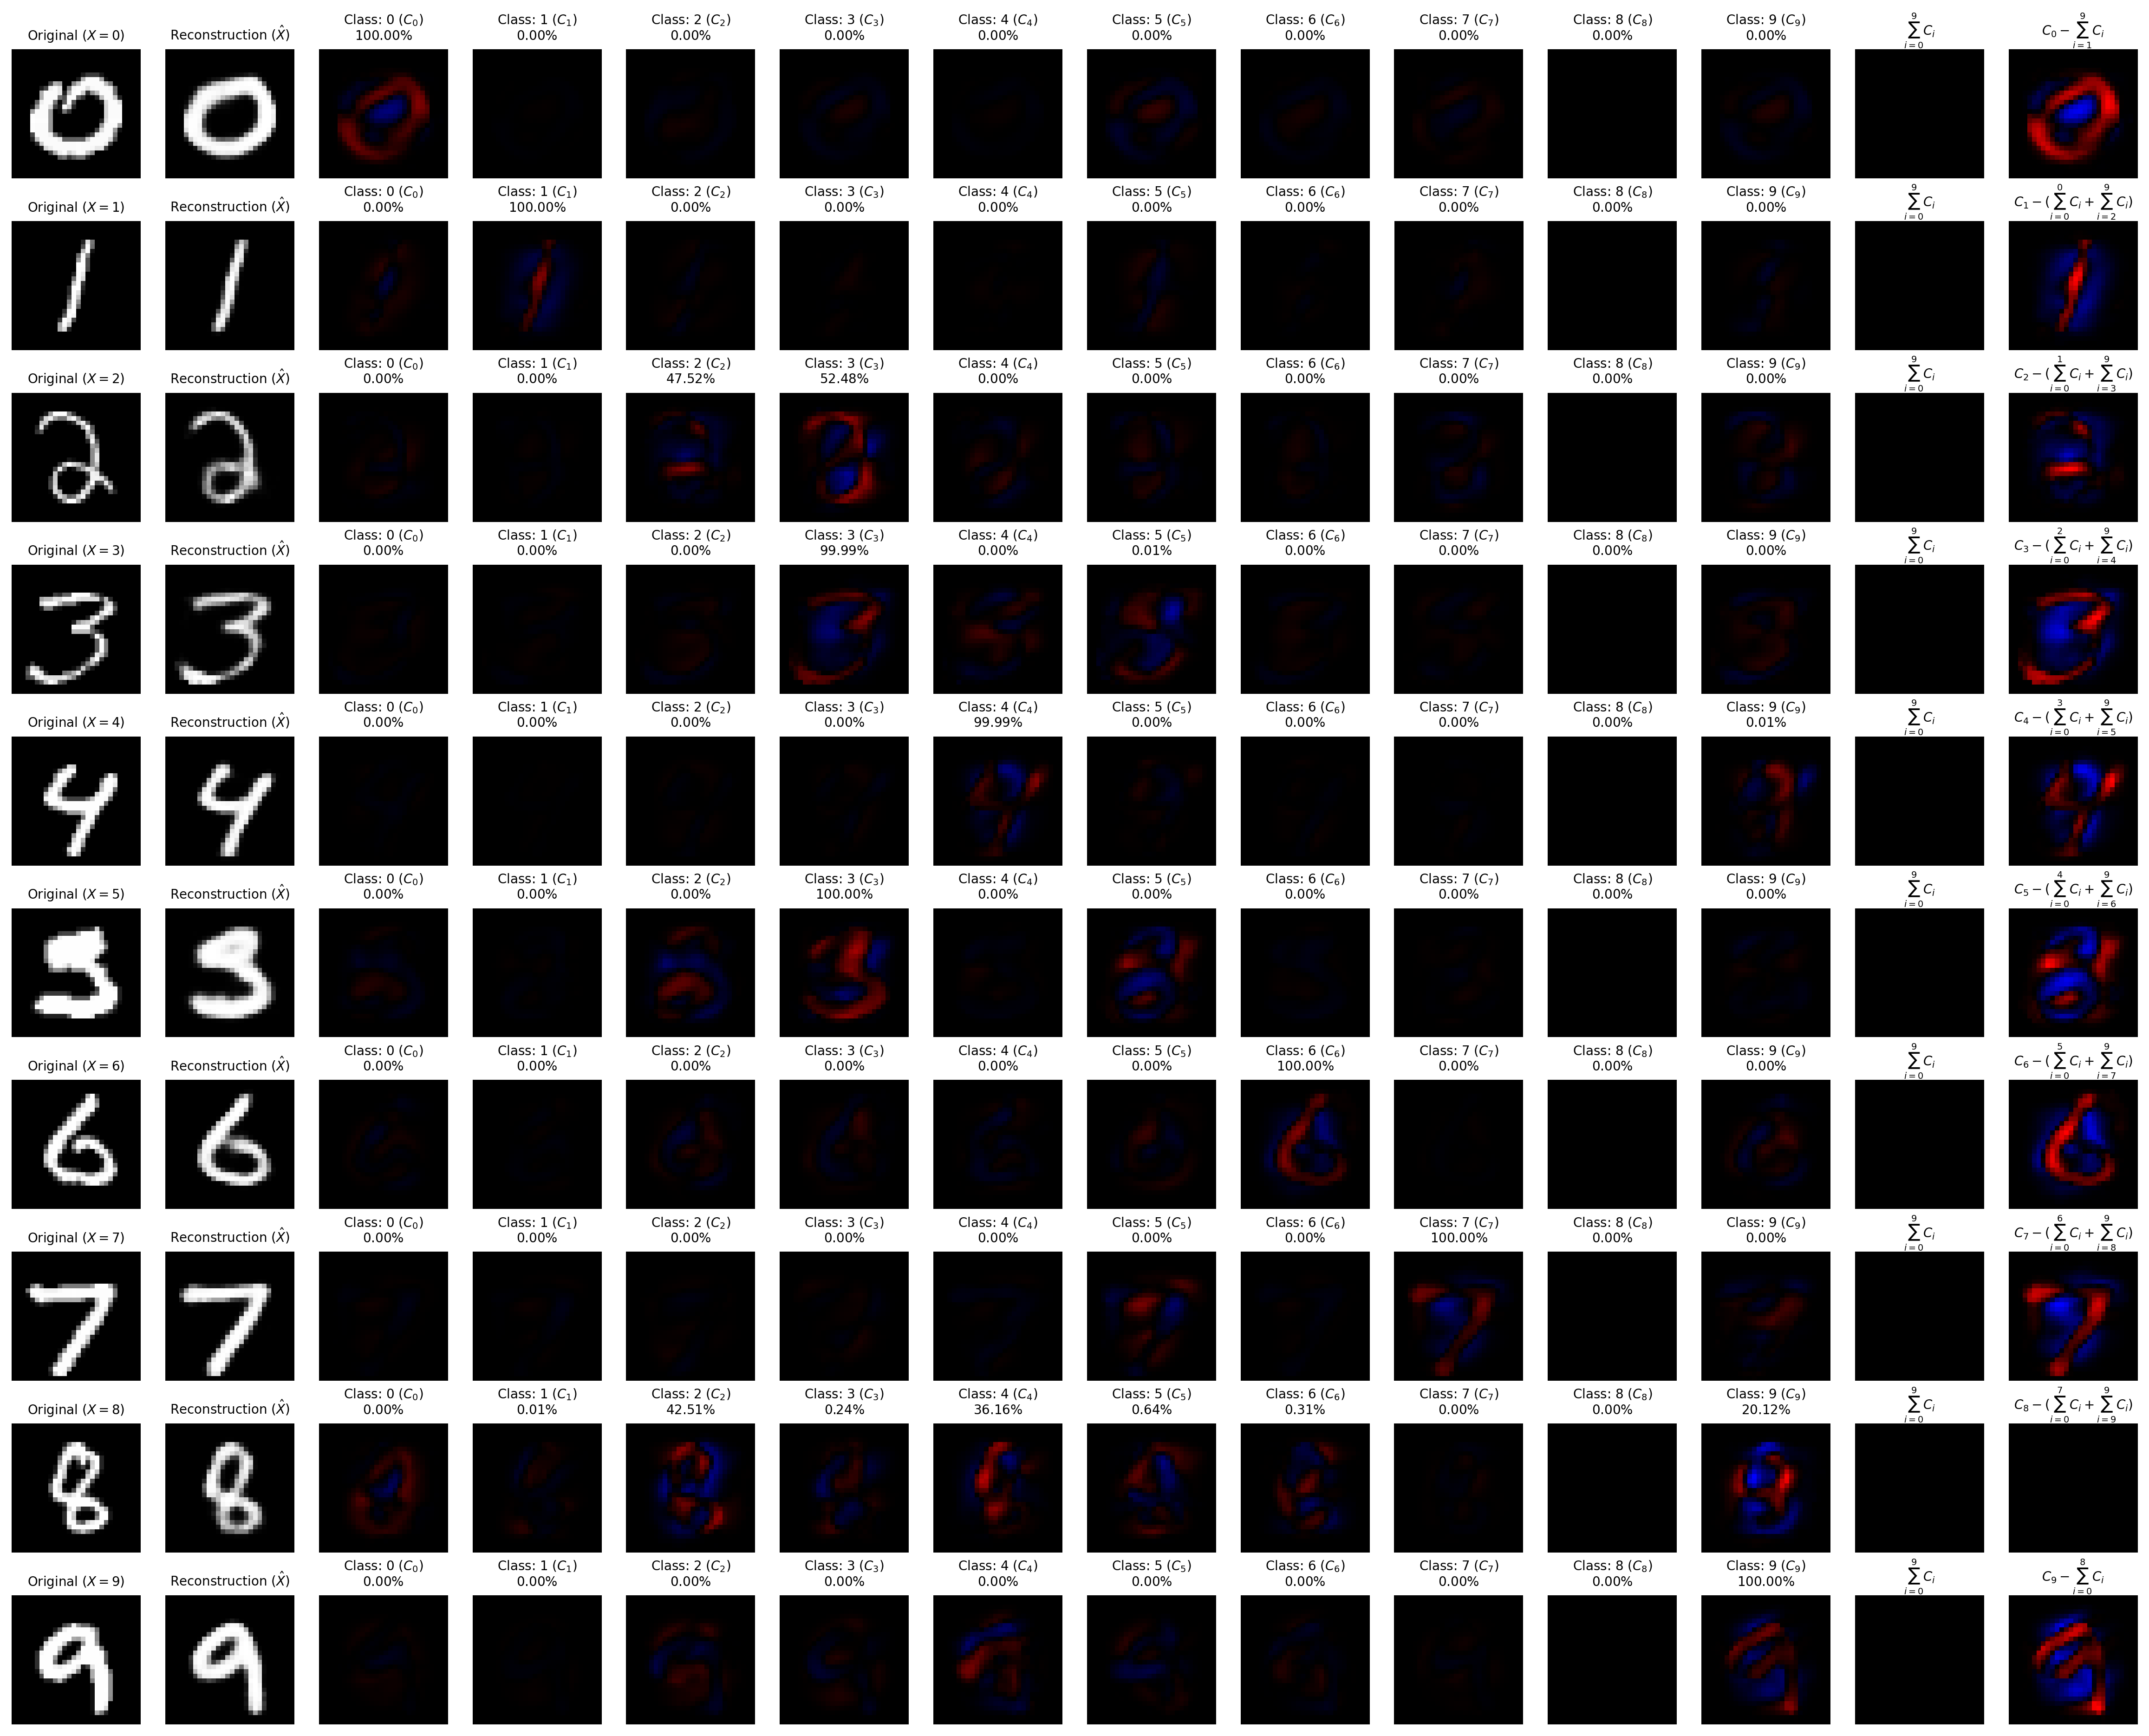

In [25]:
fig = plt.figure(figsize=(20,15), dpi=250) 
rows = 10
columns = 15

for row in range(rows):
    slot = row*columns

    sample,label = samples[row]
    sample = sample.numpy(force=True)
    label = int(label.item())
    predict = mnist(sample)
    recon = predict.reconstruction().numpy(force=True)
    digit = predict.digits()[0]
    cls = predict.classification().tolist()

    recon_xai = predict.explain("reconstruction", "permutation")
    cls_xai = predict.explain("classification", "permutation")


    fig.add_subplot(rows,columns,slot+1)
    plt.imshow(sample, cmap="gray")
    plt.axis('off')
    plt.title(f"Original ($X={{{label}}}$)", size=8)
        
    fig.add_subplot(rows,columns,slot+2)
    plt.imshow(recon, cmap="gray")
    plt.axis('off')
    plt.title("Reconstruction ($\hat{{X}}$)", size=8)
        
    shaps = cls_xai.combine(recon_xai).shap_values

    delta_shap: np.ndarray = shaps[label] - (shaps[:label].sum(axis=0) + shaps[label+1:].sum(axis=0))
    shap_sum = shaps.sum(axis=0)
    norm = max([np.max(np.abs(shaps)), np.max(np.abs(delta_shap)), np.max(np.abs(shap_sum))])

    for j,shap in enumerate(shaps):
        fig.add_subplot(rows,columns,slot+j+3)
        im = np.zeros((28,28,3), dtype=np.float32)
        red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
        blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
        im[:,:,0] = red
        im[:,:,2] = blue
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"Class: {j} ($C_{j}$)\n${cls[j]*100:.2f}$%", size=8)

    
    fig.add_subplot(rows,columns,slot+j+4)
    im = np.zeros((28,28,3), dtype=np.float32)
    red = np.argwhere(shap_sum > 0)
    blue = np.argwhere(shap_sum < 0)
    im[:,:,0]
    red = np.where(shap_sum > 0, shap_sum/norm, np.zeros_like(shap_sum))
    blue = np.where(shap_sum < 0, -shap_sum/norm, np.zeros_like(shap_sum))
    im[:,:,0] = red
    im[:,:,2] = blue
    plt.imshow(im)
    plt.axis('off')
    plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{C_i}}$", size=8)

    fig.add_subplot(rows,columns,slot+j+5)
    im = np.zeros((28,28,3), dtype=np.float32)
    red = np.where(delta_shap > 0, delta_shap/norm, np.zeros_like(delta_shap))
    blue = np.where(delta_shap < 0, -delta_shap/norm, np.zeros_like(delta_shap))
    im[:,:,0] = red
    im[:,:,2] = blue
    plt.imshow(im)
    plt.axis('off')
    if row == 0:
        plt.title(f"$C_{{{label}}} - \sum_{{i={1}}}^{{{rows-1}}}{{C_i}}$", size=8)
    elif row == (rows - 1):
        plt.title(f"$C_{{{label}}} - \sum_{{i={0}}}^{{{rows-2}}}{{C_i}}$", size=8)
    else:
        plt.title(f"$C_{{{label}}} - (\sum_{{i={0}}}^{{{label-1}}}{{C_i}} + \sum_{{i={label+1}}}^{{{rows-1}}}{{C_i}})$", size=8)

fig.tight_layout()
fig.show()